In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406 ],
                                 std=[0.229, 0.224, 0.225 ])
 
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),
    'validation':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])}
 
image_datasets = {
    'train':
        datasets.ImageFolder('/content/drive/My Drive/train2', data_transforms['train']),  #不能把train這檔案放在其他資料夾 ex: my drive/png/train 不行
    'validation':
        datasets.ImageFolder("/content/drive/My Drive/test2", data_transforms['validation'])}
 
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=20,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=20,
            shuffle=False,
            num_workers=4)}

classes = ('gintama','sakura','date')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


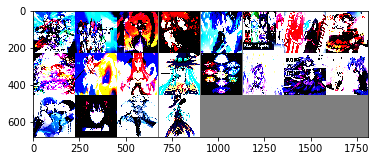

gintama gintama


In [ ]:
import torchvision
def imshow(img):
    img = img  + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(dataloaders['validation'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
model = models.resnet50(pretrained=True).to(device)
 
for param in model.parameters():
    param.requires_grad = False
 
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 3)).to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=8):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
 
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
 
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model
 
model_trained = train_model(model, criterion, optimizer, num_epochs=8)

Epoch 1/8
----------
train loss: 1.1986, acc: 0.3333
validation loss: 1.1841, acc: 0.4270
Epoch 2/8
----------
train loss: 1.1345, acc: 0.4778
validation loss: 0.8730, acc: 0.6517
Epoch 3/8
----------
train loss: 0.8255, acc: 0.7556
validation loss: 0.7339, acc: 0.8427
Epoch 4/8
----------
train loss: 0.7776, acc: 0.7333
validation loss: 0.6312, acc: 0.8764
Epoch 5/8
----------
train loss: 0.7100, acc: 0.7556
validation loss: 0.5315, acc: 0.9775
Epoch 6/8
----------
train loss: 0.6264, acc: 0.8556
validation loss: 0.4879, acc: 0.9438
Epoch 7/8
----------
train loss: 0.4639, acc: 0.9222
validation loss: 0.4610, acc: 0.8539
Epoch 8/8
----------
train loss: 0.4615, acc: 0.9111
validation loss: 0.3492, acc: 0.9888


In [ ]:
torch.save(model_trained.state_dict(),'/content/drive/My Drive/ai/study/anime3_weight.h5')

In [ ]:
validation_img_paths = [
                        "/content/drive/My Drive/test2/櫻花莊/23.jpg",
                        "/content/drive/My Drive/test2/data a live/6.jpg",
                        "/content/drive/My Drive/test2/銀魂/17.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]#"/content/drive/My Drive/test2/銀魂/4.jpg",

In [ ]:
print(img_list)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=444x250 at 0x7F37139DC710>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=550x364 at 0x7F37139E9080>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225 at 0x7F37139E9198>]


In [ ]:
validation_batch = torch.stack([data_transforms['train'](img).to(device)
                                for img in img_list])
 
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

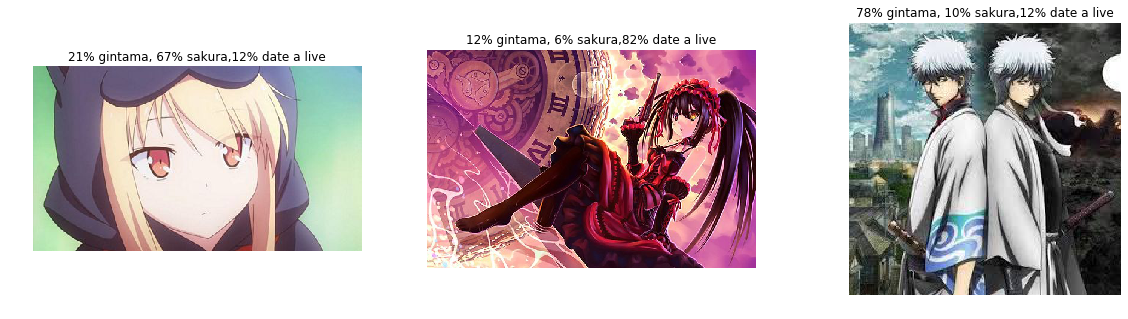

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
   ax = axs[i]
   ax.axis('off')
   ax.set_title("{:.0f}% gintama, {:.0f}% sakura,{:.0f}% date a live".format(100*pred_probs[i,2],
                                                         100*pred_probs[i,1],100*pred_probs[i,0]))
   ax.imshow(img)